In [1]:
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt

conversationPath = './Chat.txt' 
fontpathDJB="./DJB The Generic.ttf"

AColor="#3b5e91"
BColor="#FA6A21"

from matplotlib import font_manager as fm, rcParams
prop = fm.FontProperties(fname=fontpathDJB)
fontNameDJB="DJB The Generic"
prop = fm.FontProperties(fname=fontpathDJB)

ToSavePlot=True

OrangeBlue = ["#E25128", "#F15A2A", "#F47635", "#28A5DE", "#0095CB"]
OrangeBlue2 =  ["#F73A00", "#FA6A21", "#F58311", "#00A6E0", "#4E8AD9", "#2B3A55"] 
OrangeBlue3=["#FA6A21", "#FA6A21", "#F58311", "#00A6E0", "#4E8AD9", "#3b5e91"] 
PastelPinkBlue=["#D97EC0", "#956FA6", "#684F73", "#4E8AD9", "#2B3A55"]
OrangeBlueMod = ["#E65623", "#F5610F", "#F58311", "#16A3E0", "#00A6E0", "#0058CC"]


colorstomap=OrangeBlue3
AColor=colorstomap[len(colorstomap)-1]
BColor=colorstomap[0]

colorstomap.reverse() 

C:\Users\ishaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


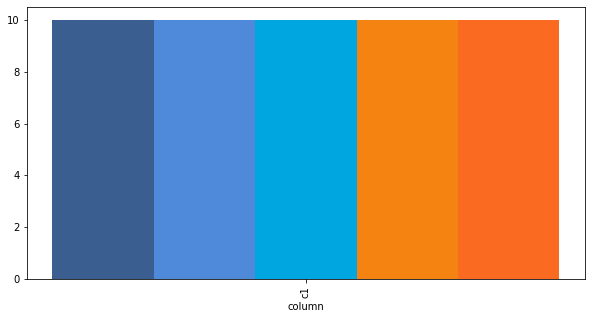

<Figure size 432x288 with 0 Axes>

In [2]:
df1 = pd.DataFrame([['g1','c1',10],['g2','c1',10],['g3','c1',10],['g4','c1',10],
                   ['g5','c1',10]],columns=['group','column','val'])


barWidth=5
df2=df1.pivot("column", "group", "val")
ax=df2.plot(kind='bar',color= colorstomap,width=barWidth,legend=False,figsize=(10,5))
ax = plt.figure(frameon=False)
ax.patch.set_visible(False)

#plt.savefig('demo.png', transparent=False)
ax.show()

# Data Preprocessing

In [3]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateTime(s):
    pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), (([0-9][0-9])|[0-9]):([0-9][0-9]) ([a][m]|[p][m]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):
    splitLine = line.split(' - ') 
    dateTime = splitLine[0] 
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:]) 
    if startsWithAuthor(message): 
        splitMessage = message.split(': ')
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

parsedData = [] 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)    
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None 
    
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateTime(line): #this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer

df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
#df.head()

#df is main chat dataframe

In [4]:
df.shape #dimensions of said dataframe

(94411, 4)

In [5]:
author_value_counts = df['Author'].value_counts() # Number of messages per auth
author_value_counts.head(25) 

Ishaan Aditya    52097
Sahiti Sri       42313
Name: Author, dtype: int64

# Data Analysis

In [6]:
def getindexforMedia(df0):
    indexlist=[]
    count=0
    for i in df0['Message']:
        if i == '<Media omitted>':
            #have to search for (file attached)
            indexlist.append(count)
        if i.find('(file attached)') != -1:
            indexlist.append(count)
        count+=1
        
    return indexlist

messages_df = df.drop(getindexforMedia(df)) 
# Drops all rows of the data frame containing media messages
messages_df['Chars'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Words Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df.head(2)
#this will be the main dataframe we will use

,Date,Time,Author,Message,Chars,Words Count
0,02/01/19,1:18 pm,Ishaan Aditya,Because of things you did.,26,5
1,02/01/19,1:18 pm,Ishaan Aditya,And you not accepting your faults.,34,6


In [7]:
import calendar
def DayOTW(s):
  dtlst=s.split('/')
  
  my_date=datetime.date(int(dtlst[2]),int(dtlst[1]),int(dtlst[0])) #format is year month day
  #return(calendar.day_name[my_date.weekday()])
  return (calendar.day_name[my_date.weekday()])

messages_df['Day'] = messages_df['Date'].apply(lambda s : DayOTW(s))
messages_df.head()

,Date,Time,Author,Message,Chars,Words Count,Day
0,02/01/19,1:18 pm,Ishaan Aditya,Because of things you did.,26,5,Wednesday
1,02/01/19,1:18 pm,Ishaan Aditya,And you not accepting your faults.,34,6,Wednesday
2,02/01/19,1:18 pm,Ishaan Aditya,And when I did join you act like a know-it-all,46,10,Wednesday
3,02/01/19,1:18 pm,Ishaan Aditya,Saying yeh nai ho skta woh nai ho sakta.,40,9,Wednesday
4,02/01/19,1:19 pm,Sahiti Sri,???,3,1,Wednesday


In [8]:
def HourSplitTo24(x):
    ap=x.split(" ")
    hour=int(ap[0].split(":")[0]) 
    alpha=ap[1]
    if alpha=="am" and hour==12:
        return "24"
    if alpha=="pm" and hour==12:
        return "12"
    if alpha=="am":
        return(str(hour))
    if alpha=="pm":
        return (str(hour+12))

messages_df['Hour'] = messages_df['Time'].apply(lambda x : HourSplitTo24(x)) 
messages_df.head(2)

WordList=[]
patternq='\?+|\s+'
for i in messages_df.Message:
  row=re.split(r';|,|:|\/|\*|\n|-|\.|\s',i)
  for j in row:
    x=re.sub(patternq,'',j)
    j=x
  WordList.append(row)

messages_df.insert(4,"Words",WordList)
#df.drop('Words', axis=1, inplace=True)
messages_df.head(5)
messages_df.reset_index(drop=True, inplace=True)

# Stopwords

In [9]:
stopwords1=[]
#words = ' '.join(df_Mobj['Word'])
#print(words)
newwordstostop=["??",'attached)','(file','omitted>','<Media','?',"JPG","jpg","IMG","HTTPS","VID","mp4","com","youtu","webp","maps","google"]
newerwords=["opus","ptt","PDF","be","STK","thi","www","i","I"]
wastop=[]
#WA0000 type stop
alist=["%.4d" % i for i in range(0,500)]
for i in alist:
  stop="WA"+str(i)
  wastop.append(stop)
  #print(stop, end=' ')

for i in newwordstostop:
  stopwords1.append(i)
for i in wastop:
  stopwords1.append(i)
for i in newerwords:
  stopwords1.append(i)

In [10]:
stopwords2=["you","me","to"]
for i in stopwords1:
  stopwords2.append(i)

#stopwords_Act = nltk.corpus.stopwords.words('english')
#for i in stopwords_Act:
#  stopwords2.append(i)

stopwords2.append("h")
stopwords2.append("love")
stopwords2.append("")
#print(stopwords2)

# Words-Frequencies


In [11]:
#Author-Words DataFrame
def getAuthorWordList(df0):
    AuthWord=[]
    
    for i in range(len(df0.Words)):
      auth=df0.Author[i]
      for j in df0.Words[i]:
        row=[]
        row.append(auth)
        row.append(j)
        AuthWord.append(row)
    
    return(AuthWord)

#print(len(messages_df.Words))
#authword_df.head()

In [12]:
NameA="Ishaan Aditya"
NameB="Sahiti Sri"

def getindexofStopwords(df0):
    indexnames=[]
    count=0
    for i in df0['Word']:
      boolval=i in stopwords2
      if boolval:
        indexnames.append(count)
      count+=1
    return(indexnames)

def getindexofRegexPattern(dfo,pat="\?+"):
    pat="\?+"
    indexnames=[]
    count=0
    for i in dfo['Word']:
        boolval=bool(re.search(pat,i))
        if boolval:
            indexnames.append(count)
        count+=1
    return indexnames
    
def freqWordsList(namestr,numoffreqs=50):
    WordsIshaan_df=authword_df[authword_df.Author == namestr]
    #WordsI=WordsIshaan_df["Word"].value_counts()
    #WordsI.head()
    #WordsIshaan_df.describe()
    #return WordsI
    WordsIshaan_df.drop(WordsIshaan_df.index[getindexofStopwords(WordsIshaan_df)],inplace=True)
    #return WordsIshaan_df
    WordsI=WordsIshaan_df["Word"].value_counts()
    WordsI.head(1000)
    df_IWords = pd.DataFrame(WordsI)
    df_IWords=df_IWords.reset_index()
    df_IWords.columns=['Word','Frequency']
    
    df_IWords.drop(df_IWords.index[getindexofRegexPattern(df_IWords)],inplace=True)
    #df_IWords.head()
    df_IWords.reset_index(drop=True)
    FreqWordsIshaan=df_IWords.head(numoffreqs).to_numpy().tolist()
    for i in FreqWordsIshaan:
      i[0]=i[0].lower()
    
    return FreqWordsIshaan
    
authword_df=pd.DataFrame(getAuthorWordList(messages_df),columns=['Author','Word'])
print(freqWordsList(NameA))

[['the', 2015], ['na', 1863], ["i'm", 1721], ['you', 1632], ['jaan', 1568], ['baby', 1546], ['hai', 1541], ['nai', 1350], ['ho', 1298], ['it', 1240], ['this', 1131], ['a', 1107], ['more', 1095], ['toh', 1068], ["i'll", 1001], ['know', 999], ['so', 989], ["don't", 948], ['for', 940], ['jaan', 938], ['and', 936], ['do', 905], ['that', 881], ['of', 832], ['kya', 817], ['rahe', 814], ['have', 812], ['is', 804], ['my', 787], ['not', 781], ['yes', 733], ['and', 714], ['yr', 703], ['se', 701], ['bhi', 688], ['sorry', 681], ['hi', 681], ['please', 671], ['ke', 667], ['your', 655], ['want', 638], ['but', 625], ['ka', 619], ['was', 614], ['baby', 605], ['baat', 595], ['much', 580], ['kar', 573], ['hm', 569], ['haan', 569]]


C:\Users\ishaa\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
AWords=freqWordsList(NameA)
BWords=freqWordsList(NameB)
CommonFreqWords=[]
for i in AWords:
  word1=i[0]
  for j in BWords:
    word2=j[0]
    if word2==word1:
      CommonFreqWords.append(j[0])
Set1=set(CommonFreqWords)
CommonFreqWords=list(Set1)

In [14]:
#Appending Frequencies of Said Common Words From Both Lists
def SearchWord(s,Arr):
  count=0
  for i in Arr:
    if s == i[0]:
      return count
    count+=1
  return -1

FreqWordsComWFreq=[]

for i in CommonFreqWords:
  row=[]
  freqA=AWords[SearchWord(i,AWords)][1]
  freqB=BWords[SearchWord(i,BWords)][1]
  row=[i ,freqA,freqB]
  FreqWordsComWFreq.append(row)

In [15]:
def Sort(sub_li): 
    return(sorted(sub_li, key = lambda x: x[1],reverse=False))     
  
FreqWordsComWFreq=(Sort(FreqWordsComWFreq))

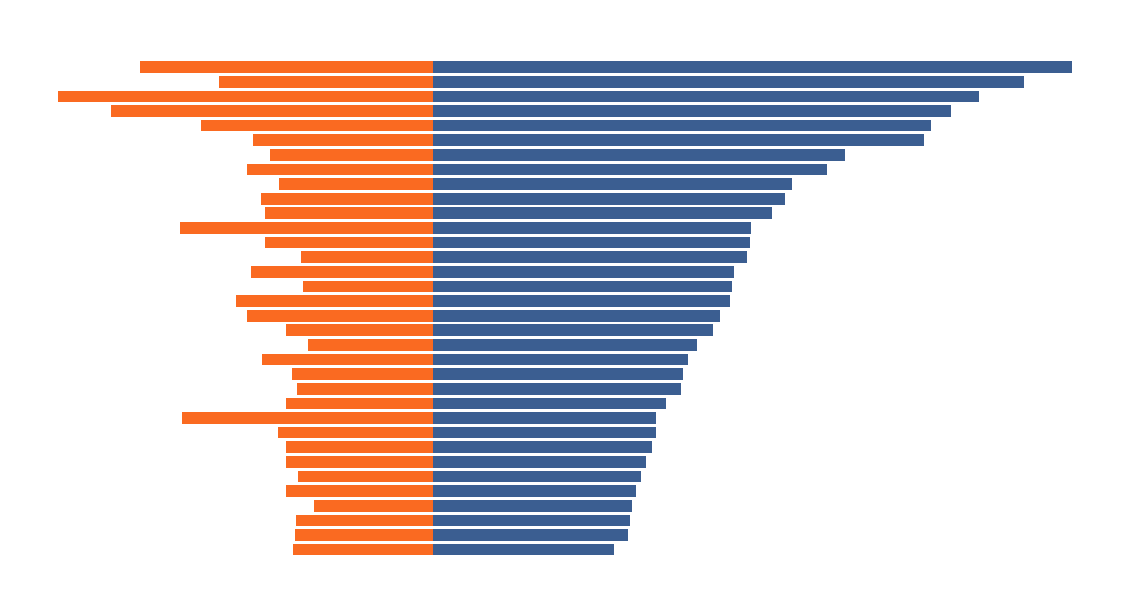

<Figure size 1080x720 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
import numpy as np

bars1=[i[1] for i in FreqWordsComWFreq]
bars2=[-1*i[2] for i in FreqWordsComWFreq]
textar=[i[0].upper() for i in FreqWordsComWFreq]

barWidth=4
gap=5
#print(bars2)
fig, ax = plt.subplots(figsize=(20, 10))

fig.patch.set_alpha(0.0)

plt.figure(figsize=(15,10))
r=np.arange(len(bars1))
q=[i*gap for i in r]
ax.barh(q,bars1,height=barWidth,color=AColor)
ax.barh(q,bars2,height=barWidth,color=BColor)

for i in r:
  ax.text(bars1[i]+10,(q[i]*(1))-1,textar[i],fontsize=barWidth+10,color='white',fontproperties=prop)

ax.set_title("Most used words apart from the obvious",fontproperties=prop,color="white",fontsize=25)
ax.set_xticks([-1000,-500,0,500,1000])
ax.set_yticks([])
ax.set_axisbelow(True)
ax.set_xticklabels(["1000","500","0","500","1000"],color='white',fontproperties=prop,fontsize=10)
ax.grid(color='White',linewidth=0.5)
ax.tick_params(axis='x', colors='white')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

if ToSavePlot:
    fig.savefig('./plots/most_used_words.png',dpi=700,transparent=True,quality=100)
#fig.savefig()
plt.show()


# Timeline Plot

In [17]:
import datetime
datesop=datetime.date(2020,4,1)
#df_DateFreq = df_DateFreq.drop(df_DateFreq[(df_DateFreq.Date].index)
#df_DateFreq.head()

#get index via comparing dates
def getindexnamesOfMessagesAboveKeydate(dfo,y=2020,m=4,d=1):
  indexnames=[]
  count=0
  keydate=datetime.date(y,m,d)
  for i in dfo['Date']:
    i.date()
    boolval=bool(i.date()>keydate)
    if boolval:
      indexnames.append(count)
    count+=1
  return indexnames

In [18]:
def createDateMsgDF(namestr,nametodrop):
    dfname=messages_df.drop(messages_df[messages_df.Author==nametodrop].index)
    dfname['Date']=pd.to_datetime(dfname['Date'])
    DFobj=pd.value_counts(dfname['Date'])

    df_DateMsg = pd.DataFrame(DFobj)
    df_DateMsg=df_DateMsg.reset_index()
    df_DateMsg.columns=['Date','Frequency']
    #df_DateMsg.head()
    
    #eliminate messages after a key date
    df_DateMsg.drop(df_DateMsg.index[getindexnamesOfMessagesAboveKeydate(df_DateMsg)],inplace=True)
    return df_DateMsg

DateMsgA=createDateMsgDF(NameA,NameB)
DateMsgB=createDateMsgDF(NameB,NameA)

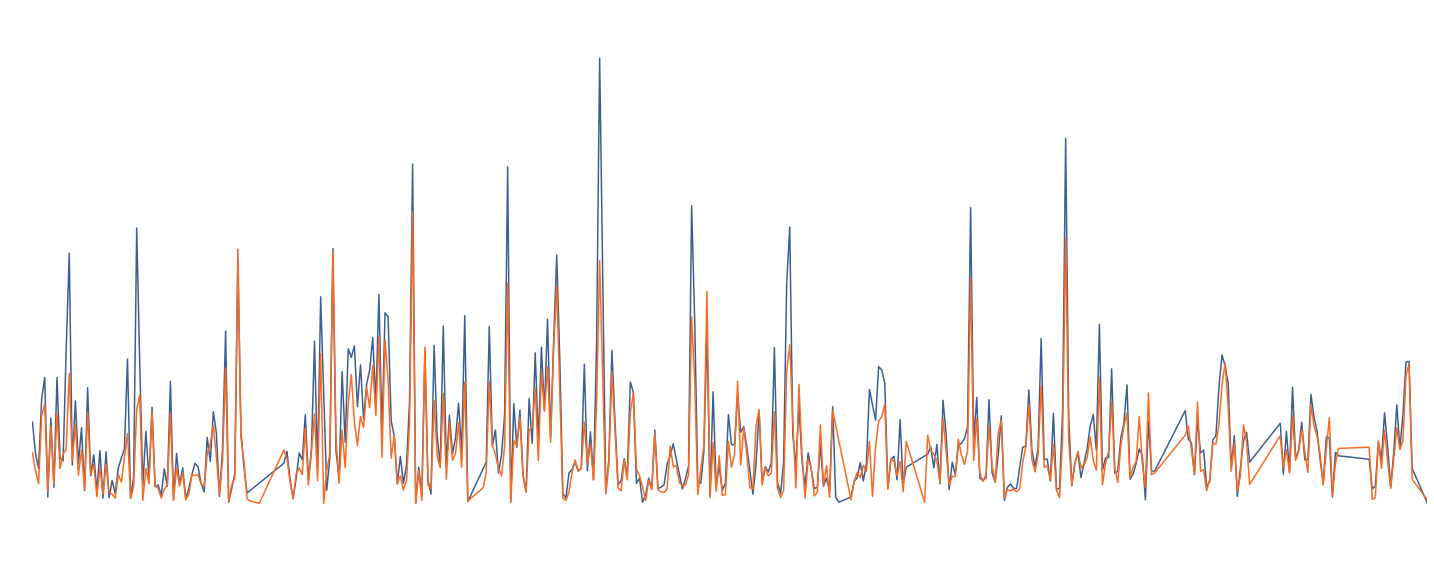

In [19]:
fig, ax = plt.subplots(figsize=(25, 10))
DateMsgA.set_index('Date')['Frequency'].plot(color=AColor)
DateMsgB.set_index('Date')['Frequency'].plot(color=BColor)

ax.set_yticks([0, 400], minor=False)
ax.yaxis.grid(True, which='major')
ax.yaxis.grid(False, which='minor')
plt.grid(color='White',linewidth=0.5)
ax.xaxis.grid(False,which='major')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_axisbelow(True)

ax.set_yticklabels([0,400],fontproperties=prop,fontsize=15)
xticklabel=["2019-01","2019-03","2019-05","2019-07","2019-09","2019-11","2020-01","2019-03"]
ax.set_xticklabels(xticklabel,fontproperties=prop,fontsize=15)
ax.set_title("Timeline of Messages",color='White',fontproperties=prop,fontsize=25)

ax.set_xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

if ToSavePlot:
    fig.savefig('./plots/timeline.png',dpi=700,transparent=True,quality=100)

plt.show()

# Radar Plot Hour


In [20]:
def getindexnamesToNOTDrop(dfo,s):
  #gets indexes of author that are not S
  indexnames=[]
  count=0
  for i in dfo['Author']:
    if i!=s:
      indexnames.append(count)
    count+=1
  return(indexnames)

def createHMdf(df0):
  HourMess=(df0['Hour'].value_counts().head(24))
  dfHM=pd.DataFrame(HourMess)
  dfHM.reset_index(inplace=True)
  dfHM.columns=['Hour','Messages']
  return(dfHM)

def createHourMessageDF(namestr):
    dfName=messages_df.drop(messages_df.index[getindexnamesToNOTDrop(messages_df,namestr)])
    dfNamex=createHMdf(dfName)
    return dfNamex


HourMessageA=createHourMessageDF(NameA)
HourMessageB=createHourMessageDF(NameB)

In [21]:
def SortAr(sub_li): 
  return(sorted(sub_li, key = lambda x: x[0],reverse=False)) 

def createListFromHourMessageDF(df0):
  HourMess=[]
  HourMess=df0.to_numpy().tolist()
  Hlist=[]
  Vlist=[]
  for i in HourMess:
    i[0]=int(i[0])
  HourMess=SortAr(HourMess)
  for i in HourMess:
    Hlist.append(int(i[0]))
    Vlist.append(i[1])
  return(Hlist,Vlist)

AHour,AValues= createListFromHourMessageDF(HourMessageA)
BHour,BValues= createListFromHourMessageDF(HourMessageB)

In [22]:
labels=([str(i) for i in AHour])
angles=[]
angles=list(np.linspace(0,2*np.pi,len(labels),endpoint=False))

def appendCirc():
  AValues.append(AValues[0])
  BValues.append(BValues[0])

appendCirc()
angles.append(angles[0])

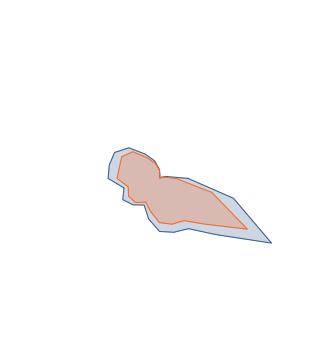

In [23]:
fig= plt.figure(figsize=(5,5))
ax=fig.add_subplot(111,polar=True)
ax.plot(angles,AValues,linewidth=1.0,color=AColor)
ax.fill(angles,AValues,alpha=0.25,color=AColor)
ax.plot(angles,BValues,linewidth=1.0,color=BColor)
ax.fill(angles,BValues,alpha=0.25,color=BColor)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_yticklabels(["","2000","","4000","","6000",""],fontproperties=prop,color='white',fontsize=10)
plt.grid(color='White',linewidth=1)
ax.set_axisbelow(True)
ax.spines['polar'].set_visible(False)

ax.set_thetagrids([i* 180/np.pi for i in angles],labels,fontproperties=prop,color="White",fontsize=10)
ax.grid(True)
ax.set_title("Messages by Hour of Day",color='White',fontproperties=prop,fontsize=17.5)

if ToSavePlot:
    fig.savefig('./plots/RadarHour.png',dpi=700,transparent=True,quality=100)

plt.show()

# Radar Plot Weekday


In [24]:
def createWDMdf(df0):
  Mess=(df0['Day'].value_counts().head(7))
  dfWDM=pd.DataFrame(Mess)
  dfWDM.reset_index(inplace=True)
  dfWDM.columns=['Day','Messages']
  return(dfWDM)

def createWeekDayMessageDF(namestr):
    dfName=messages_df.drop(messages_df.index[getindexnamesToNOTDrop(messages_df,namestr)])
    dfNamex=createWDMdf(dfName)
    return dfNamex

WDMessageA=createWeekDayMessageDF(NameA)
WDMessageB=createWeekDayMessageDF(NameB)

In [25]:
dayarray=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

def createListFromDFWD(df0):
  #this dataframe is weekday,freq
  DayMess=df0.to_numpy().tolist()
  vlist=[]
  daylist=[]
  for i in DayMess:
    i[0]=dayarray.index(i[0])  
  DayMess=SortAr(DayMess)
  for i in DayMess:
    vlist.append(i[1])
    daylist.append(i[0])
  return(daylist,vlist)

ADay,AValues=createListFromDFWD(WDMessageA)
BDay,BValues=createListFromDFWD(WDMessageB)

In [26]:
labels=[]
angles=[]
labels=([dayarray[i] for i in ADay])
angles=list(np.linspace(0,2*np.pi,len(labels),endpoint=False))

def appendCirc():
  AValues.append(AValues[0])
  BValues.append(BValues[0])

appendCirc()
angles.append(angles[0])

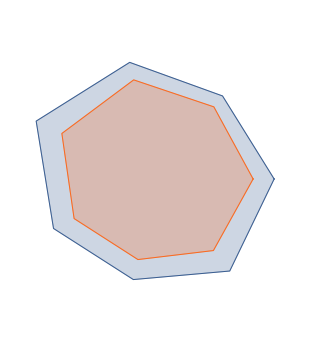

In [27]:
fig= plt.figure(figsize=(5,5))
ax=fig.add_subplot(111,polar=True)
ax.plot(angles,AValues,linewidth=1.0,color=AColor)
ax.fill(angles,AValues,alpha=0.25,color=AColor)
ax.plot(angles,BValues,linewidth=1.0,color=BColor)
ax.fill(angles,BValues,alpha=0.25,color=BColor)
ax.tick_params(axis='x', colors='White')
ax.tick_params(axis='y', colors='White')
ax.set_yticklabels(["","2000","","4000","","6000","","8000"],fontproperties=prop,color='white',fontsize=10)
plt.grid(color='White',linewidth=1)
ax.set_axisbelow(True)
ax.spines['polar'].set_visible(False)
ax.set_thetagrids([i* 180/np.pi for i in angles],labels,fontproperties=prop,color="White",fontsize=10)
ax.set_title("Messages by Day of the Week",color='White',fontproperties=prop,fontsize=17.5)
ax.grid(True)

if ToSavePlot:
    fig.savefig('./plots/RadarWeekday.png',dpi=700,transparent=True,quality=100)

plt.show()

# Donut Charts


In [28]:
WordsBY=[226942,143414]
MessagesBY=[52097,42314]
WordsUniqueBY=[15141,11972]

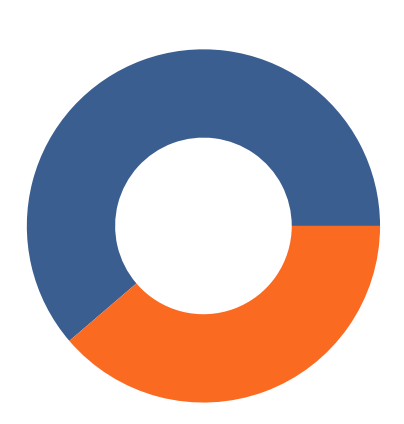

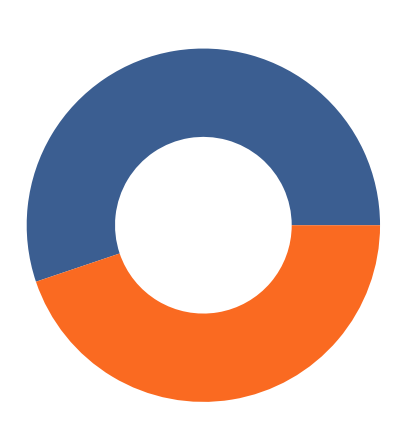

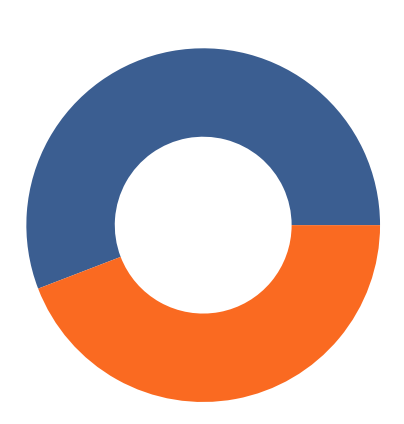

In [29]:
import matplotlib.pyplot as plt

def plot2pie(intarr,s,tit):
    Radius=0.3
    Width=(0.5)*Radius
    fig, ax = plt.subplots(figsize=(7,7))
    name="./plots/"+s+".png"
    colorz=[AColor,BColor]
    ax.pie(intarr,colors=colorz,wedgeprops=dict(width=Width),radius=Radius)
    ax.axis('equal')
    ax.set_title(tit,color='white',fontproperties=prop,fontsize=25)
    if ToSavePlot:
        fig.savefig(name,dpi=700,transparent=True,quality=100)
    plt.show()


plot2pie(WordsBY,"WordsBY","Number of Words used by each")
plot2pie(MessagesBY,"MessagesBY","Number of Messages sent by each")
plot2pie(WordsUniqueBY,"WordsUniqueBY","Number of Unique Words used by each")

# WordCloud


In [1]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import matplotlib 

ModuleNotFoundError: No module named 'wordcloud'

In [31]:
Mobj=df.Message.str.split(expand=True).stack().value_counts()
df_Mobj = pd.DataFrame(Mobj)
df_Mobj=df_Mobj.reset_index()
df_Mobj.columns=['Word','Frequency']

words = ' '.join(df_Mobj['Word'])

In [32]:
wc_mask = np.array(Image.open("./blackheart.png"))

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("mycmap", colorstomap)

In [ ]:
#background_color="black"
#background_color="rgba(255, 255, 255, 0)", mode="RGBA", 

wordcloud = WordCloud(font_path='./DJB The Generic.ttf',
                      stopwords=stopwords1,
                      background_color="rgba(255, 255, 255, 0)", mode="RGBA",
                      width=2000,
                      height=1400,
                      colormap=cmap,
                      mask=wc_mask
                     ).generate(words)
if  ToSavePlot:
    wordcloud.to_file('./plots/mywc.png')
plt.imshow(wordcloud)
plt.axis('off')
plt.show() 